# [GN-6]Fantastic Chatbot

이번 프로젝트는 Transformer를 이용하여 Chatbot을 만드는 것이다.    
- 데이타 증강(Agumented)를 통해서 부족한 데이타를 추가
- BLEU Score를 계산해 보기



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim
import re
from konlpy.tag import Mecab
import warnings
warnings.filterwarnings(action='ignore')

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)


1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


## Step 1. 데이터 다운로드

In [2]:
file_path = 'transformer/ChatbotData.csv'

df = pd.read_csv(file_path, names=['questions','answers', 'label'], skiprows=1)
df.head()

,questions,answers,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## Step 2. 데이터 정제

In [3]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    #sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    #sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

🧐 기본적으로 Tokenizer에서 기능으로 해주기에 특수문자와 공백처리는 제외함. 

## Step 3. 데이터 토큰화

In [4]:
len(df) #11823

11823

In [5]:
mecab=Mecab()

max_len = 50

que_corpus = []
ans_corpus = []

def build_corpus(df, max_len=50):
    que = []
    ans = []

    unique_question = set()
    unique_answer = set()
 
    for row in df.iterrows():
        question = row[1]['questions']
        answer = row[1]['answers']

        que_temp = preprocess_sentence(question)
        que_temp = tuple(mecab.morphs(que_temp))
        ans_temp = preprocess_sentence(answer)
        ans_temp = tuple(mecab.morphs(ans_temp))

        if que_temp not in unique_question:
            if ans_temp not in unique_answer:
                if len(que_temp) <= max_len and len(ans_temp) <= max_len:
                    unique_question.add(que_temp)
                    unique_answer.add(ans_temp)
                    que.append(list(que_temp))
                    ans.append(list(ans_temp))

    return que, ans 

que_corpus, ans_corpus = build_corpus(df)



🧐 preprocess_sentence를 통해 전처리를 진행하고, Mecab을 통해서 형태소 분석 했다. 
Question과 Answer에서 중복값을 걸러내고, 문장길이도 max_len = 50으로 설정해서 분류해 냈다.


In [6]:
que_corpus[10:20]

[['가난', '한', '자', '의', '설움'],
 ['가만', '있', '어도', '땀', '난다'],
 ['가상', '화폐', '쫄딱', '망함'],
 ['가스', '불', '켜', '고', '나갔', '어'],
 ['가스', '비', '너무', '많이', '나왔', '다'],
 ['가스', '비', '비싼데', '감기', '걸리', '겠', '어'],
 ['가장', '확실', '한', '건', '뭘까'],
 ['가족', '여행', '가', '기', '로', '했', '어'],
 ['가족', '있', '어'],
 ['가족', '끼리', '여행', '간다']]

In [7]:
len(que_corpus), len(ans_corpus)

(7640, 7640)

In [8]:
total_sentence_count = len(que_corpus)
test_sentence_count = int(total_sentence_count*0.01)
print(test_sentence_count)# 100 개반 테스트 데이타로 남겨두자
test_sentence_count = 100

76


In [9]:
# test , trans 분리
test_que_corpus = que_corpus[-test_sentence_count:]
que_corpus = que_corpus[:-test_sentence_count]

test_ans_corpus = ans_corpus[-test_sentence_count:]
ans_corpus = ans_corpus[:-test_sentence_count]



In [10]:
len(test_que_corpus),len(test_ans_corpus),len(que_corpus),len(ans_corpus)

(100, 100, 7540, 7540)

🧐 Test 데이타로 약 5%정도의 데이타인 100개를 분류해 두고, BLEU Score 계산에 이용할 예정이다.

## Step 4. Augmentation

https://yeon22.tistory.com/158   
pip install --upgrade gensim==3.8.3

Gensim  버전이 4.1.2버전이었는데, ko.bin에 만들어진 버전과 맞지 않아 downgrade gensim==3.8.3로 진행했다. 

In [11]:
from gensim.models.word2vec import Word2Vec

wv=Word2Vec.load('transformer/ko.bin')

In [12]:
wv.most_similar("탐험")

[('항해', 0.6469576358795166),
 ('탐사', 0.6048390865325928),
 ('여행', 0.5845088362693787),
 ('정복', 0.5619137287139893),
 ('개척', 0.5535061955451965),
 ('남극', 0.5296272039413452),
 ('탐험가', 0.5190513134002686),
 ('탐험대', 0.511405348777771),
 ('횡단', 0.4878459572792053),
 ('대서양', 0.4818343222141266)]

In [13]:
import random
sample_sentence = "은"
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        if wv.most_similar(tok)[0][0] is not None:
            result += wv.most_similar(tok)[0][0] + " "
    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)



From: 은
To: 은데 


In [14]:
def lexical_sub(src_sentence, wv):
    sample_tokens = src_sentence

    selected_tok = random.choice(sample_tokens)

    result = ""
    
    try:
        sim_word = wv.most_similar(selected_tok)[0][0]
    except:
        sim_word = selected_tok

    for tok in sample_tokens:
        if tok is selected_tok: 
            result += sim_word + " "
        else:
            result += tok + " "

    return result.strip().split(' ')

🧐 데이타 증강을 위한 기본 함수를 정의했다. 문장 토큰 중에서 임의로 하나를 선정해 most_similar를 찾고 있으면 그 단어를 사용하가 없으면 기본 토큰을 사용하도록 했다. 만일 공백문자나 '-'와 같은 문자를 반환하면, 의미없는 데이타가 생성되고, 아예 빼면 Question과 Answer과 쌍이 맞지 않기에 유사한 단어를 찾지 못하더라도 에러나 빈문자를 반환하기 보다, 기존 문장을 반환하도록 했다. 
이렇게 하면 전체적으로 중복 데이타가 생길 수 있지만, 따로 이후에 중복데이타 제거는 진행하지 않았다. 



In [15]:
temp = lexical_sub(['항해','를', '떠날', '시간','이다.'],wv)

print(temp)

['탐험', '를', '떠날', '시간', '이다.']


In [16]:
# questin Argumented
que_a_corpus=[]

for idx, sen in enumerate(que_corpus):
    new_src = lexical_sub(sen, wv)
    que_a_corpus.append(new_src)  
    
print(len(que_a_corpus))

7540


In [17]:
# answer argumanted 
ans_a_corpus=[]

for idx, sen in enumerate(ans_corpus):
    new_src = lexical_sub(sen, wv)
    ans_a_corpus.append(new_src)  
    
print(len(ans_a_corpus))

7540


In [18]:
que_corpus[30:40]

[['간장', '치킨', '시켜야', '지'],
 ['간접흡연', '싫', '어'],
 ['갈까', '말', '까', '고민', '돼'],
 ['감기', '같애'],
 ['감기', '걸린', '것', '같', '아'],
 ['감기', '가', '오', '려나'],
 ['감미', '로운', '목소리', '좋', '아'],
 ['감정', '이', '쓰레기통', '처럼', '엉망진창', '이', '야'],
 ['감정', '컨트롤', '을', '못', '하', '겠', '어'],
 ['감히', '나', '를', '무시', '하', '는', '애', '가', '있', '어']]

In [19]:
que_a_corpus[30:40]

[['고추장', '치킨', '시켜야', '지'],
 ['간접흡연', '힘들', '어'],
 ['갈까', '말로', '까', '고민', '돼'],
 ['달라붙', '같애'],
 ['감기', '걸린', '것', '똑같', '아'],
 ['감기', '가', '오', '여러해'],
 ['감미', '로운', '목소리', '괜찮', '아'],
 ['감정', '이', '쓰레기통', '처럼', '엉망진창', '그러', '야'],
 ['욕망', '컨트롤', '을', '못', '하', '겠', '어'],
 ['감히', '나의', '를', '무시', '하', '는', '애', '가', '있', '어']]

In [20]:
ans_corpus[30:40]

[['맛있', '게', '드세요'],
 ['저', '도', '싫', '어요'],
 ['가세', '요'],
 ['병원', '가', '세요'],
 ['이럴', '때', '잘', '쉬', '는', '게', '중요', '해요'],
 ['따뜻', '하', '게', '관리', '하', '세요'],
 ['저', '도', '듣', '고', '싶', '네요'],
 ['자신', '을', '더', '사랑', '해', '주', '세요'],
 ['그건', '습관', '이', '에요'],
 ['콕', '집', '어서', '물', '어', '보', '세요']]

In [21]:
ans_a_corpus[30:40]

[['맛있', '도록', '드세요'],
 ['저', '도', '힘들', '어요'],
 ['격분', '요'],
 ['병원', '놀드', '세요'],
 ['이럴', '때', '잘', '쉬', '는', '게', '핵심적', '해요'],
 ['따뜻', '하', '게', '관리', '하', 'ㅂ시오'],
 ['제', '도', '듣', '고', '싶', '네요'],
 ['자신', '을', '더', '사랑', '해', '주기도', '세요'],
 ['그건', '습관', '그러', '에요'],
 ['콕', '집', '어서', '물', '어', '살펴보', '세요']]

In [22]:
# 데이타 결합

question_corpus=[]
answer_corpus = []

question_corpus = que_corpus + que_a_corpus + que_corpus + que_a_corpus
answer_corpus = ans_corpus + ans_corpus + ans_a_corpus + ans_a_corpus


🧐 데이타 결합   
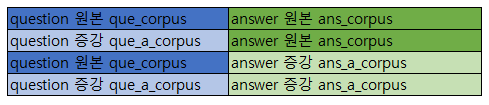

In [23]:
len(question_corpus), len(answer_corpus) 

(30160, 30160)

In [24]:
question_corpus[12329]

['쭉', '좋', '다가', '오늘', '갑자기', '너무', '보', '고', '싶', '고', '생각나', '네', 'ㅠㅠ']

In [25]:
answer_corpus[12329]

['그런', '날', '이', '있', '더라고요', '다른', '생각', '을', '해', '보', '세요']

## Step 5. 데이터 벡터화

In [26]:
# <start><end>추가

answer_corpus = [['<start>'] + sentence +['<end>'] for sentence in answer_corpus]

answer_corpus[12329]

['<start>',
 '그런',
 '날',
 '이',
 '있',
 '더라고요',
 '다른',
 '생각',
 '을',
 '해',
 '보',
 '세요',
 '<end>']

In [27]:
vocab_size=20000

def gen_tokenizor(corpus): 
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>", num_words=vocab_size)
    tokenizer.fit_on_texts(corpus)
    return  tokenizer

In [28]:
chatbot_tokenizer = gen_tokenizor(question_corpus + answer_corpus)

print("Vocab Size:", len(chatbot_tokenizer.index_word))
   

Vocab Size: 7179


In [29]:
MAX_LEN = 50
enc_tensor = chatbot_tokenizer.texts_to_sequences(question_corpus)
dec_tensor = chatbot_tokenizer.texts_to_sequences(answer_corpus)

enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, padding='post', maxlen=MAX_LEN)
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(dec_tensor, padding='post', maxlen=MAX_LEN)

enc_train = enc_tensor
dec_train = dec_tensor


## Step 6. 모델 설계

In [30]:
# positional_encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)

        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights
    
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out
    
#Encoder Layer 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn
    
# Decoder 레이어 구현하기
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
    
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
    
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


 ## Step 7. 훈련하기

In [31]:

n_layers = 1            # encoder, decoder layer를 각각 2개층 쌓음
d_model = 368           # dense층 및 모든 모델의 dimention 
n_heads = 8             # multiheadattention을 위한 head 갯수
d_ff = 1024             # FeedForward 층의 dimention   
dropout = 0.2           


src_vocab_size = vocab_size
tgt_vocab_size = vocab_size
pos_len = 600           # position endoding의 최대값

warmup_steps = 1000     #learning rate


transformer = Transformer(
        n_layers,
        d_model,
        n_heads,
        d_ff,
        src_vocab_size,
        tgt_vocab_size,
        pos_len,
        dropout
)


In [32]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)



learning_rate = LearningRateScheduler(d_model, warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)



loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns


In [33]:
def evaluate(question, model, src_tokenizer, tgt_tokenizer):
    que_temp = preprocess_sentence(question)
    que_temp = tuple(mecab.morphs(que_temp))
    
    que_temp = src_tokenizer.texts_to_sequences(que_temp)     
    _input = tf.keras.preprocessing.sequence.pad_sequences(que_temp, padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.word_index['<start>']], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        ids.append(predicted_id)
        if tgt_tokenizer.word_index['<end>'] == predicted_id:
            result = tgt_tokenizer.sequences_to_texts([ids])[0]
            return question, result, enc_attns, dec_attns, dec_enc_attns

        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        
    result = tgt_tokenizer.sequences_to_texts([ids])[0]
    return question, result, enc_attns, dec_attns, dec_enc_attns
    

In [34]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
        evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Question: %s' % (sentence))
    print('Answer: {}'.format(result))

In [35]:
# 학습

#from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm

BATCH_SIZE = 64
EPOCHS = 12

examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

for epoch in range(EPOCHS):
    total_loss = 30
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    #if (epoch % 2 == 1):
    for example in examples:
        translate(example, transformer, chatbot_tokenizer, chatbot_tokenizer)

  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 정말 많이 힘들 죠 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 좋 은 것 같 은데요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 좋 은 선택 이 에요 <end>
Question: 집에 있는다는 소리야.
Answer: 좋 은 사람 이 있 길 바랄 게요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 다른 생각 을 해 보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 내일 은 오늘 내일 이 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹 푹
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 득템 했 네요 <end>
Question: 집에 있는다는 소리야.
Answer: 편하 고 싶 은 편하 고 싶 은 편하 고 나가 요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 그 을 읽 을 했 는지 생각 해 보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 힘든 시간 이 었 나요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 득템 했 나 봐요 <end>
Question: 집에 있는다는 소리야.
Answer: 같이 데려다 주 려나 봐요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 다른 생각 을 해 보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 헛헛 하 군요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 휴식 도 필요 해요 <end>
Question: 집에 있는다는 소리야.
Answer: 집 무작정 찾아가 집 마련 축하 드려요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 다른 생각 을 해 살펴보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 힘든 하루 였 나요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 떨리 죠 <end>
Question: 집에 있는다는 소리야.
Answer: 집 이 편하 고 싶 죠 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 다른 생각 을 해 보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 저 도 아침 이 군요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 득템 했 요 <end>
Question: 집에 있는다는 소리야.
Answer: 집 에 같이 들어가 요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 좀 더 어떻게 해 보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 힘든 일 이 군요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 떨리 는 떨리 죠 <end>
Question: 집에 있는다는 소리야.
Answer: 데려다 주 려나 봐요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 그 으면 해 보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 힘든 일 이 약 이 되 었 어요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 득템 하 고 있 죠 <end>
Question: 집에 있는다는 소리야.
Answer: 집 이 사 나 봐요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 어떻게 해 보 세요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 오늘 은 힘내 려 하 지 말 아요 저 에게 기대 세요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 득템 하 고 요 <end>
Question: 집에 있는다는 소리야.
Answer: 집 이 제일 데려다 줄 때 이 죠 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 그 자체 로 힘드 니까요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 오늘 은 힘내 려 시키 지 말 아요 저 에게 기대 세요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 득템 하 게 요 <end>
Question: 집에 있는다는 소리야.
Answer: 집 에 찾아가 고 나 서 쉬 고 집 에 요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 그 사람 을 통해 에너지 를 쓰 니까요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 오늘 도 고생 이 수많 았 어요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 득템 하 게 요 <end>
Question: 집에 있는다는 소리야.
Answer: 집 에 요 <end>


  0%|          | 0/472 [00:00<?, ?it/s]

Question: 지루하다, 놀러가고 싶어.
Answer: 그 사람 에게 좋 을 것 같 아요 <end>
Question: 오늘 일찍 일어났더니 피곤하다.
Answer: 오늘 은 힘내 요 <end>
Question: 간만에 여자친구랑 데이트 하기로 했어.
Answer: 휴식 도 좋 은 요 <end>
Question: 집에 있는다는 소리야.
Answer: 데려다 주 려나 봐요 <end>


In [36]:
translate('또 하루 멀어져간다.', transformer, chatbot_tokenizer, chatbot_tokenizer)

Question: 또 하루 멀어져간다.
Answer: 오늘 도 헤어지 면 좋 을 거 예요 <end>


In [37]:
translate('나는 문제 없어', transformer, chatbot_tokenizer, chatbot_tokenizer)

Question: 나는 문제 없어
Answer: 나 를 무시 하 지 않 고 존중 하 는지 살펴보 세요 <end>


In [38]:
translate('어제 술을 많이 먹었어.', transformer, chatbot_tokenizer, chatbot_tokenizer)

Question: 어제 술을 많이 먹었어.
Answer: 힘껏 울 고 천천히 털 어 내 길 바랄 게요 <end>


## 8. 평가하기

### 8.1 BLEU score

In [39]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    

    reference=tgt_sentence
    #candidate = translate(' '.join(src_sentence), model, src_tokenizer, tgt_tokenizer)
    
    pieces, candidate, enc_attns, dec_attns, dec_enc_attns = \
        evaluate(' '.join(src_sentence), model, src_tokenizer, tgt_tokenizer)
    
    score = sentence_bleu(' '.join(reference), ' '.join(candidate), weights=(1,0,0,0))
    
    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


In [40]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    avg_score = total_score / sample_size
    print("Num of Sample:", sample_size)
    print(f"Total Score:{avg_score:.3f}", )
    
print("슝=3")

슝=3


In [41]:
from nltk.translate.bleu_score import sentence_bleu
# ref = '친구들이 사랑하니까 예뻐졌대.'
# cand = '행복 바이러스에 감염되셨군요.'

ref=['친구', '들', '이', '사랑', '하', '니까', '예뻐졌', '대']
cand = ['행복', '바이러스', '에', '감염', '되', '셨', '군요']
score = sentence_bleu(' '.join(ref), ' '.join(cand), weights=(1,0,0,0))

print(f'{score:.3f}')

0.105


In [42]:
test_idx = 5

eval_bleu_single(transformer, 
                 test_que_corpus[test_idx], 
                 test_ans_corpus[test_idx], 
                 chatbot_tokenizer, 
                 chatbot_tokenizer,
                 verbose=True)


Source Sentence:  ['친구', '들', '이', '사랑', '하', '니까', '예뻐졌', '대']
Model Prediction:  친구 들 이 친구 를 사귈 수 있 겠 네요 <end>
Real:  ['행복', '바이러스', '에', '감염', '되', '셨', '군요']
Score: 0.052632



0.05263157894736841

In [43]:
eval_bleu(transformer, test_que_corpus, test_ans_corpus, chatbot_tokenizer, chatbot_tokenizer, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Num of Sample: 100
Total Score:0.063


🧐 테스트 데이타 100에 대해서 BLEU Score 0.066으로 기록 되었다.    
weights=(1,0,0,0) 로 1-gram 기준으로 산출하였다. 다른 기준들은 수치가 너무 적게 나와 그나마 높게 나오는 수치로 측정했다. 


### 8.2 Beam Search Decoder

In [44]:
# calc_prob() 구현
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)


# beam_search_decoder() 구현
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    
    tokens = src_tokenizer.texts_to_sequences(sentence)

    
    src_in = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                            #maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tgt_tokenizer.word_index['<start>']

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()
    

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.word_index['<end>']:
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(tgt_tokenizer.word_index['<end>'])
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred

def calculate_bleu(reference, candidate, weights=[1,0,0,0]):
    return sentence_bleu(' '.join(reference),
                            candidate,
                            weights=weights,
                            ) # smoothing_function=SmoothingFunction(epsilon=1e-12).method1


# Q. beam_bleu() 함수를 구현해봅시다.
def beam_bleu(reference, ids, tokenizer):

    total_score = 0.0
    for _id in ids:

        candidate = tokenizer.sequences_to_texts([_id])[0]
        score = calculate_bleu(reference, candidate)

        print("Reference:", ' '.join(reference))
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))
        print("="*50)
        print("\n")
        total_score += score
        
    return total_score / len(ids)

In [49]:
# Q. 인덱스를 바꿔가며 확인해 보세요
test_idx = 50

ids = \
beam_search_decoder(test_que_corpus[test_idx],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    chatbot_tokenizer,
                    chatbot_tokenizer,
                    beam_size=5)
bleu = beam_bleu(test_ans_corpus[test_idx], ids, chatbot_tokenizer)

print(bleu)

Reference: 뭐 든 함께 하 려는 것 도 좋 겠 지만 오래 붙 어 잇 는다고 해서 사랑 이 더 커 지 거나 깊 어 지 지 않 아요
Candidate: <start> 아침 도 좋 아 하 는 게 뭔지 알아보 세요 <end>
BLEU: 0.21052631578947367


Reference: 뭐 든 함께 하 려는 것 도 좋 겠 지만 오래 붙 어 잇 는다고 해서 사랑 이 더 커 지 거나 깊 어 지 지 않 아요
Candidate: <start> 아침 도 좋 아 하 는 게 하루 알아보 세요 <end>
BLEU: 0.1842105263157895


Reference: 뭐 든 함께 하 려는 것 도 좋 겠 지만 오래 붙 어 잇 는다고 해서 사랑 이 더 커 지 거나 깊 어 지 지 않 아요
Candidate: <start> 아침 도 좋 아 하 는 게 아침 알아보 세요 <end>
BLEU: 0.1842105263157895


Reference: 뭐 든 함께 하 려는 것 도 좋 겠 지만 오래 붙 어 잇 는다고 해서 사랑 이 더 커 지 거나 깊 어 지 지 않 아요
Candidate: <start> 아침 도 좋 아 하 는 마음 뭔지 알아보 세요 <end>
BLEU: 0.20512820512820512


Reference: 뭐 든 함께 하 려는 것 도 좋 겠 지만 오래 붙 어 잇 는다고 해서 사랑 이 더 커 지 거나 깊 어 지 지 않 아요
Candidate: <start> 아침 도 좋 죠 하 는 게 뭔지 알아보 세요 <end>
BLEU: 0.21052631578947367


0.19892037786774627


🧐 Beam Search 에 대한 BLEU score도 산출했다. 에러 나서 포기할까 했는데, 오기 발동~!
소스는 비록 깔끔하진 않지만 완료한 것으로 만족한다. 

# 회고

- CV data 증강을 위한 방법들은 이미 알고 있었는데, NLP에서 데이타 증강을 처음으로 해보았다. 
- 유사어를 기반으로 데이타 증강을 진행하면서, 적은 데이타로도 데이타를 만들어 낼 수 있다는 것이 재미있었다. 
- 증강된 데이타에서도 Question-Answer의 쌍을 맞추려 하다보니 중복 데이타가 생길 수 밖에 없는 구조가 되었다.
- 추가적으로 중복을 제거할까 하다가 데이타 수가 적어 그냥 진행했다. 
- 증강된 Question- 증강된 Answer 세트는 과연 양질의 데이타 였을지 검증이 필요해 보인다. 
- Tokenizer를 사용할 때 keras Tokenizer 대신 SentencePiece를 사용하려 했는데 실패했다. Vocab_size가 2000내외로 밖에 생성이 안되며 에러가 났고, 억지로 생성을 해서 진행을 했지만, Answer 품질이 생각보다 좋지 않았다. 
- Beam Search Decoder는 시도해서 해냈다. 
- 그래도 이번 프로젝트를 하면서 재미있었던 것은 엉뚱하고 재미있는 답변들이 나와서 빵 터졌다. 🤣 Q: 나는 문제 없어 - A:생길꺼에요. 
- 데이터 증강을 통해서도 재미있는 내용들이 많았다. Q: 간장 치킨 시켜줘 - QA(증강): 간장 아이스크림 시켜줘 🍗🍦 
- 의지가 되는 챗봇 탄생 😁 Q: 오늘 일찍 일어났더니 피곤하다.- A:오늘 은 힘내 려 하 지 말 아요 저 에게 기대 세요
- 위로가 되는 챗봇 😏 Q: 어제 술을 많이 먹었어.- A:힘껏 울 고 천천히 털 어 내 길 바랄 게요 